In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import torch
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [ ]:
import numpy as np

dec_data = np.loadtxt('/content/drive/MyDrive/Copy of Train_Dst_NoAuction_DecPre_CF_7.txt')
dec_train = dec_data[:, :int(np.floor(dec_data.shape[1] * 0.8))]
dec_val = dec_data[:, int(np.floor(dec_data.shape[1] * 0.8)):]

dec_test1 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_7.txt')
dec_test2 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test3 = np.loadtxt('/content/drive/MyDrive/Copy of Test_Dst_NoAuction_DecPre_CF_8.txt')
dec_test = np.hstack((dec_test1, dec_test2, dec_test3))

print(dec_data.shape)
print(dec_train.shape)
print(dec_val.shape)
print(dec_test.shape)

(149, 254750)
(149, 203800)
(149, 50950)
(149, 159822)


In [ ]:
# load packages
import pandas as pd
import pickle
import numpy as np
import keras
import tensorflow as tf
from keras import backend as K
from keras.models import load_model, Model
from keras.layers import Flatten, Dense, Dropout, Activation, Input, LSTM, Reshape, Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers import LeakyReLU
# from keras.layers.advanced_activations import LeakyReLU
from keras.utils import to_categorical
# from keras.utils import np_utils

from sklearn.metrics import classification_report, accuracy_score
import matplotlib.pyplot as plt

# set random seeds
np.random.seed(1)
tf.random.set_seed(2)

In [ ]:
def prepare_x(data):
    df1 = data[:40, :].T
    return np.array(df1)

def get_label(data):
    lob = data[-5:, :].T
    return lob

def data_classification(X, Y, T):
    [N, D] = X.shape
    df = np.array(X)
    dY = np.array(Y)
    dataY = dY[T - 1:N]
    dataX = np.zeros((N - T + 1, T, D))
    for i in range(T, N + 1):
        dataX[i - T] = df[i - T:i, :]
    return dataX.reshape(dataX.shape + (1,)), dataY

def prepare_x_y(data, k, T):
    x = prepare_x(data)
    y = get_label(data)
    x, y = data_classification(x, y, T=T)
    y = y[:,k] - 1
    y = to_categorical(y, 3)
    return x, y

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer

class AttentionLayer(Layer):
    def __init__(self, **kwargs):
        super(AttentionLayer, self).__init__(**kwargs)

    def build(self, input_shape):
        # Create a trainable weight variable for this layer.
        self.W = self.add_weight(name='attention_weight',
                                 shape=(input_shape[-1], input_shape[-1]),
                                 initializer='random_normal',
                                 trainable=True)
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        # Calculate attention scores
        e = tf.keras.backend.dot(x, self.W)

        # Calculate attention weights using softmax activation
        a = tf.keras.activations.softmax(e, axis=-2)

        # Apply attention weights to the input sequence
        output = x * a

        # Sum the weighted inputs to get the attention output
        output = tf.keras.backend.sum(output, axis=-2)

        return output

    def compute_output_shape(self, input_shape):
        return input_shape


In [ ]:
k = 4 # which prediction horizon
T = 10 # the length of a single input i. e lookback_timestep THIS HYPERPARAMETER IS FINE TUNED FOR MODEL CONVERGENCE
n_hiddens = 64
checkpoint_filepath = '/content/drive/MyDrive/path_to_your_model_checkpoints/'
# checkpoint_filepath = './model_tensorflow2/weights'

In [ ]:
# Training Dataset Shrinking
dec_train = dec_train[:,:50000]
print(dec_train.shape)
trainX_CNN, trainY_CNN = prepare_x_y(dec_train, k, T)
print(trainX_CNN.shape, trainY_CNN.shape)

(149, 50000)
(49991, 10, 40, 1) (49991, 3)


In [ ]:
# Testing Dataset Shrinking
dec_test = dec_test[:,:20000]
print(dec_test.shape)
testX_CNN, testY_CNN = prepare_x_y(dec_test, k, T)
print(testX_CNN.shape, testY_CNN.shape)

(149, 20000)
(19991, 10, 40, 1) (19991, 3)


In [ ]:

# Validation Dataset Shrinking
dec_val = dec_val[:,:10000]
print(dec_val.shape)
valX_CNN, valY_CNN = prepare_x_y(dec_val, k, T)
print(valX_CNN.shape, valY_CNN.shape)

(149, 10000)
(9991, 10, 40, 1) (9991, 3)


In [ ]:
print(trainX_CNN.shape, trainY_CNN.shape)
print(valX_CNN.shape, valY_CNN.shape)
print(testX_CNN.shape, testY_CNN.shape)

(49991, 10, 40, 1) (49991, 3)
(9991, 10, 40, 1) (9991, 3)
(19991, 10, 40, 1) (19991, 3)


In [ ]:
def create_deeplob(T, NF, number_of_lstm):
    input_lmd = Input(shape=(T, NF, 1))

    # build the convolutional block
    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(input_lmd)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 2), strides=(1, 2))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    conv_first1 = Conv2D(32, (1, 10))(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)
    conv_first1 = Conv2D(32, (4, 1), padding='same')(conv_first1)
    conv_first1 = keras.layers.LeakyReLU(alpha=0.01)(conv_first1)

    # build the inception module
    convsecond_1 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)
    convsecond_1 = Conv2D(64, (3, 1), padding='same')(convsecond_1)
    convsecond_1 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_1)

    convsecond_2 = Conv2D(64, (1, 1), padding='same')(conv_first1)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)
    convsecond_2 = Conv2D(64, (5, 1), padding='same')(convsecond_2)
    convsecond_2 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_2)

    convsecond_3 = MaxPooling2D((3, 1), strides=(1, 1), padding='same')(conv_first1)
    convsecond_3 = Conv2D(64, (1, 1), padding='same')(convsecond_3)
    convsecond_3 = keras.layers.LeakyReLU(alpha=0.01)(convsecond_3)

    convsecond_output = keras.layers.concatenate([convsecond_1, convsecond_2, convsecond_3], axis=3)
    conv_reshape = Reshape((int(convsecond_output.shape[1]), int(convsecond_output.shape[3])))(convsecond_output)
    conv_reshape = keras.layers.Dropout(0.2, noise_shape=(None, 1, int(conv_reshape.shape[2])))(conv_reshape, training=True)

    # build the last LSTM layer
    conv_lstm = LSTM(number_of_lstm, return_sequences=True)(conv_reshape)

    # add an attention layer
    attention_output = AttentionLayer()(conv_lstm)

    # build the output layer
    out = Dense(3, activation='softmax')(attention_output)

    model = Model(inputs=input_lmd, outputs=out)
    adam = keras.optimizers.Adam(lr=0.0001)
    model.compile(optimizer=adam, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

deeplob = create_deeplob(trainX_CNN.shape[1], trainX_CNN.shape[2], n_hiddens)
deeplob.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 10, 40, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 10, 20, 32)           96        ['input_1[0][0]']             
                                                                                                  
 leaky_re_lu (LeakyReLU)     (None, 10, 20, 32)           0         ['conv2d[0][0]']              
                                                                                                  
 conv2d_1 (Conv2D)           (None, 10, 20, 32)           4128      ['leaky_re_lu[0][0]']         
                                                                                              

In [ ]:
%%time

model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_loss',
    mode='auto',
    save_best_only=True)

deeplob.fit(trainX_CNN, trainY_CNN, validation_data=(valX_CNN, valY_CNN),
            epochs=50, batch_size=128, verbose=2, callbacks=[model_checkpoint_callback])

Epoch 1/50
391/391 - 23s - loss: 0.9600 - accuracy: 0.4493 - val_loss: 1.0880 - val_accuracy: 0.4022 - 23s/epoch - 60ms/step
Epoch 2/50
391/391 - 4s - loss: 0.9270 - accuracy: 0.5119 - val_loss: 1.0918 - val_accuracy: 0.3894 - 4s/epoch - 9ms/step
Epoch 3/50
391/391 - 4s - loss: 0.8194 - accuracy: 0.6054 - val_loss: 1.0302 - val_accuracy: 0.4520 - 4s/epoch - 9ms/step
Epoch 4/50
391/391 - 5s - loss: 0.6564 - accuracy: 0.7023 - val_loss: 0.9589 - val_accuracy: 0.5027 - 5s/epoch - 12ms/step
Epoch 5/50
391/391 - 4s - loss: 0.5903 - accuracy: 0.7393 - val_loss: 0.9483 - val_accuracy: 0.5048 - 4s/epoch - 9ms/step
Epoch 6/50
391/391 - 4s - loss: 0.5516 - accuracy: 0.7610 - val_loss: 0.9720 - val_accuracy: 0.5120 - 4s/epoch - 9ms/step
Epoch 7/50
391/391 - 4s - loss: 0.5181 - accuracy: 0.7796 - val_loss: 0.9804 - val_accuracy: 0.5098 - 4s/epoch - 11ms/step
Epoch 8/50
391/391 - 4s - loss: 0.4923 - accuracy: 0.7922 - val_loss: 0.9993 - val_accuracy: 0.5185 - 4s/epoch - 10ms/step
Epoch 9/50
391/391

In [ ]:
deeplob.load_weights(checkpoint_filepath)
pred = deeplob.predict(testX_CNN)

625/625 [==============================] - 3s 4ms/step


In [ ]:
print('accuracy_score:', accuracy_score(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1)))
print(classification_report(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), digits=4))

accuracy_score: 0.7904056825571507
              precision    recall  f1-score   support

           0     0.7874    0.7675    0.7773      7821
           1     0.8653    0.8332    0.8490      5457
           2     0.7383    0.7822    0.7596      6713

    accuracy                         0.7904     19991
   macro avg     0.7970    0.7943    0.7953     19991
weighted avg     0.7922    0.7904    0.7909     19991



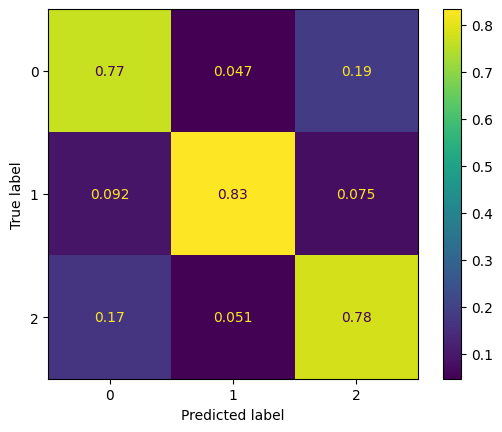

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
c = confusion_matrix(np.argmax(testY_CNN, axis=1), np.argmax(pred, axis=1), normalize="true")
disp = ConfusionMatrixDisplay(c)
disp.plot()
plt.show()

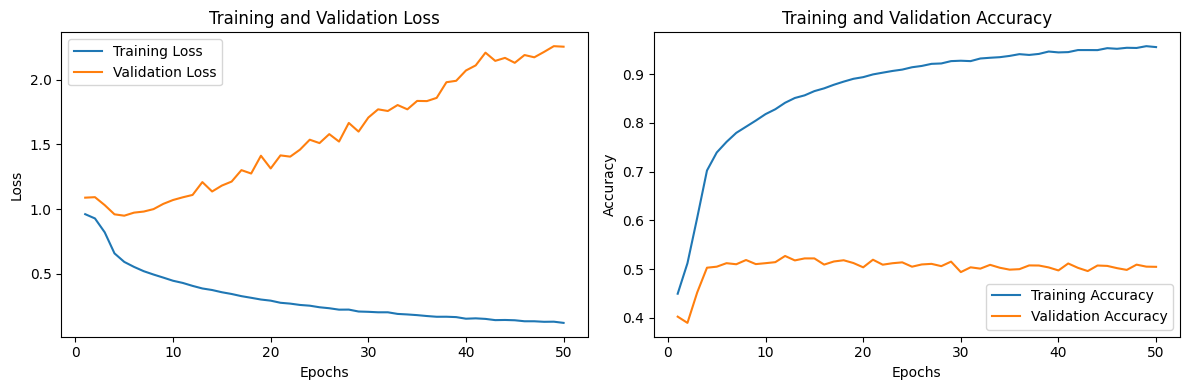

In [ ]:
import matplotlib.pyplot as plt

# Extract values from the training logs
epochs = range(1, 51)  # Assuming you trained for 50 epochs
train_loss = [0.9600, 0.9270, 0.8194, 0.6564, 0.5903, 0.5516, 0.5181, 0.4923, 0.4686, 0.4441,
              0.4272, 0.4044, 0.3844, 0.3724, 0.3551, 0.3416, 0.3249, 0.3121, 0.2987, 0.2900,
              0.2735, 0.2670, 0.2567, 0.2510, 0.2388, 0.2312, 0.2202, 0.2207, 0.2058, 0.2035,
              0.1998, 0.1998, 0.1872, 0.1831, 0.1778, 0.1708, 0.1651, 0.1654, 0.1625, 0.1501,
              0.1529, 0.1486, 0.1391, 0.1403, 0.1380, 0.1303, 0.1302, 0.1261, 0.1270, 0.1177]

val_loss = [1.0880, 1.0918, 1.0302, 0.9589, 0.9483, 0.9720, 0.9804, 0.9993, 1.0399, 1.0699,
            1.0909, 1.1092, 1.2087, 1.1359, 1.1817, 1.2128, 1.3013, 1.2751, 1.4129, 1.3143,
            1.4155, 1.4059, 1.4601, 1.5371, 1.5109, 1.5804, 1.5226, 1.6671, 1.5999, 1.7086,
            1.7725, 1.7596, 1.8057, 1.7725, 1.8376, 1.8363, 1.8612, 1.9825, 1.9936, 2.0735,
            2.1130, 2.2116, 2.1480, 2.1712, 2.1329, 2.1933, 2.1756, 2.2174, 2.2619, 2.2578]

train_acc = [0.4493, 0.5119, 0.6054, 0.7023, 0.7393, 0.7610, 0.7796, 0.7922, 0.8048, 0.8181,
             0.8281, 0.8414, 0.8512, 0.8566, 0.8653, 0.8710, 0.8784, 0.8848, 0.8906, 0.8940,
             0.8996, 0.9032, 0.9067, 0.9095, 0.9143, 0.9170, 0.9213, 0.9221, 0.9269, 0.9277,
             0.9269, 0.9323, 0.9338, 0.9350, 0.9376, 0.9412, 0.9396, 0.9417, 0.9466, 0.9448,
             0.9454, 0.9496, 0.9496, 0.9495, 0.9535, 0.9522, 0.9543, 0.9539, 0.9576, 0.9557]

val_acc = [0.4022, 0.3894, 0.4520, 0.5027, 0.5048, 0.5120, 0.5098, 0.5185, 0.5101, 0.5120,
           0.5141, 0.5268, 0.5177, 0.5218, 0.5218, 0.5091, 0.5155, 0.5180, 0.5123, 0.5035,
           0.5191, 0.5089, 0.5119, 0.5137, 0.5048, 0.5094, 0.5106, 0.5059, 0.5152, 0.4937,
           0.5035, 0.5008, 0.5086, 0.5026, 0.4987, 0.4997, 0.5074, 0.5072, 0.5033, 0.4971,
           0.5114, 0.5024, 0.4958, 0.5072, 0.5064, 0.5018, 0.4982, 0.5090, 0.5049, 0.5045]

# Plotting the training loss and validation loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Training Loss')
plt.plot(epochs, val_loss,  label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

# Plotting the training accuracy and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Training Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()
